Gemstone classification using Transfer learning(Pytorch)

Transfer learning 


Wherein we use pre existing models for feature extraction and put it to use for our own classification.

The dataset can be loaded into a google colab file using the below code cells.

In [ ]:
 ! pip install -q kaggle

In [ ]:
! mkdir .kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lsind18/gemstones-images

 74% 41.0M/55.2M [00:00<00:00, 67.1MB/s]
100% 55.2M/55.2M [00:00<00:00, 86.9MB/s]


The dataset is unzipped to extract the train and test images from their respective folder.

In [ ]:
! unzip gemstones-images.zip -d images

We load the images as dataloaders (provided by PyTorch) to help us convert the images tensors (transformed using Transformer) and map them with their class labels to make processing easier.

In [ ]:
from torchvision import datasets
import torch as torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

train_data_location='images/train'
test_data_location='images/test'

batch_size=10
num_workers = 0
valid_size = 0.2

transform = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform1 = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_d = datasets.ImageFolder(train_data_location, transform=transform)
test_d = datasets.ImageFolder(test_data_location, transform=transform1)

num_train = len(train_d)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
trainloader = torch.utils.data.DataLoader(train_d,
                   sampler=train_sampler, batch_size=batch_size,num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_d,
                   sampler=valid_sampler, batch_size=batch_size,num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_d,
                   batch_size=batch_size,num_workers=num_workers)

The following classes of gemstones are present in the dataset.

In [ ]:
train_d.classes  #all the classes present

['Alexandrite',
 'Almandine',
 'Amazonite',
 'Amber',
 'Amethyst',
 'Ametrine',
 'Andalusite',
 'Andradite',
 'Aquamarine',
 'Aventurine Green',
 'Aventurine Yellow',
 'Benitoite',
 'Beryl Golden',
 'Bixbite',
 'Bloodstone',
 'Blue Lace Agate',
 'Carnelian',
 'Cats Eye',
 'Chalcedony',
 'Chalcedony Blue',
 'Chrome Diopside',
 'Chrysoberyl',
 'Chrysocolla',
 'Chrysoprase',
 'Citrine',
 'Coral',
 'Danburite',
 'Diamond',
 'Diaspore',
 'Dumortierite',
 'Emerald',
 'Fluorite',
 'Garnet Red',
 'Goshenite',
 'Grossular',
 'Hessonite',
 'Hiddenite',
 'Iolite',
 'Jade',
 'Jasper',
 'Kunzite',
 'Kyanite',
 'Labradorite',
 'Lapis Lazuli',
 'Larimar',
 'Malachite',
 'Moonstone',
 'Morganite',
 'Onyx Black',
 'Onyx Green',
 'Onyx Red',
 'Opal',
 'Pearl',
 'Peridot',
 'Prehnite',
 'Pyrite',
 'Pyrope',
 'Quartz Beer',
 'Quartz Lemon',
 'Quartz Rose',
 'Quartz Rutilated',
 'Quartz Smoky',
 'Rhodochrosite',
 'Rhodolite',
 'Rhodonite',
 'Ruby',
 'Sapphire Blue',
 'Sapphire Pink',
 'Sapphire Purple',
 '

The function is written to help us visualise the tensor images.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  #to tensor image

We can visualis some of the images below.

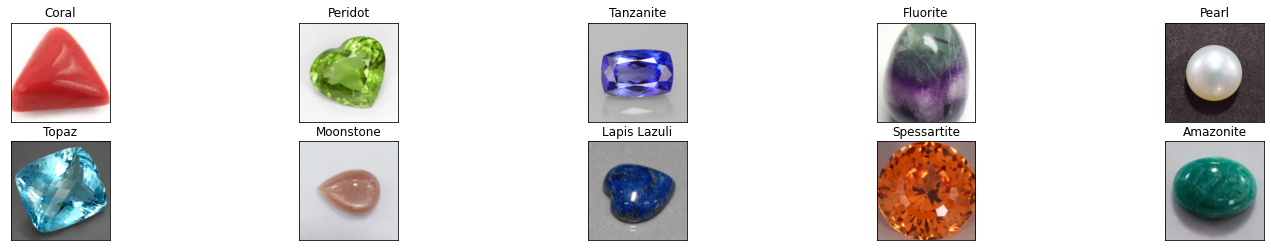

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

images,labels = next(iter(trainloader))
class_index=labels.tolist()
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_d.classes[class_index[idx]])

We create a predefined existing model Alexnet for feature extraction of the images.

In [ ]:
from torchvision import models

In [ ]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The structure of the CNN 

In [ ]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in alexnet.features.parameters():
    param.requires_grad = False

As we have only 87 classes to classify into , we change the last fully connected layer of the model to output it to 87.

In [ ]:
import torch.nn as nn
alexnet.classifier[6]=nn.Linear(4096,87)

We define the loss and optimizers.

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(alexnet.classifier.parameters(), lr=0.001)

Now , it;s time to train our model!

In [ ]:
n_epochs = 10
alexnet.train()

for e in range(n_epochs):
    train_loss=0.0
    for data,target in trainloader:
        optimizer.zero_grad()
        out=alexnet(data)
        loss=criterion(out,target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
    
    train_loss=train_loss/len(trainloader.dataset)
    print("Epoch: {} Training loss {:.6f}".format(e+1,train_loss))

Epoch: 1 Training loss 0.574595
Epoch: 2 Training loss 0.520285
Epoch: 3 Training loss 0.460867
Epoch: 4 Training loss 0.426937
Epoch: 5 Training loss 0.389219
Epoch: 6 Training loss 0.347775
Epoch: 7 Training loss 0.331306
Epoch: 8 Training loss 0.301622
Epoch: 9 Training loss 0.279441
Epoch: 10 Training loss 0.261615


To test out how well our model performed , we test it using the images we have in our testloader.

In [ ]:
def test(testloader, model, criterion):

    test_loss = 0.
    correct = 0.
    total = 0.

    alexnet.eval()

    for batch_idx, (data, target) in enumerate(testloader):
     
        output = model(data)

        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


test(testloader, alexnet, criterion)

Test Loss: 0.972232


Test Accuracy: 70% (255/363)


The accuracy of the model on the test images is 70% and can be improved by training on more epochs or by hyperparameter tuning.


Voila! and here you implemented a transfer learning model on pytorch.